## Analyzing generated dataset

### Import data

In [1]:
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

from importlib import reload
import analysis_util
import util
reload(analysis_util)
reload(util)

from analysis_util import analyze_outliers, plot_value_distributions, analyze_sequences, analyze_syntax_tokens, plot_values
from data_util import load_dataset, create_dataloader
import pandas as pd
import numpy as np
import torch

In [2]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, values, val_x, syntax_cats = load_dataset(datapath, 'dataset_240910_2')

min_, max_ = np.arcsinh(values.min()), np.arcsinh(values.max())
value_transform = lambda x: 2 * (torch.arcsinh(x) - min_) / (max_ - min_) - 1  # Center in range

val_transformed = value_transform(torch.tensor(values)).detach().numpy()

In [20]:
from data_util import calc_priors_and_means, load_wandb_model, create_dataloader_from_wandb

model, cfg_dict, cfg = load_wandb_model(run='r20n7uoe')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg_dict, cfg)

priors, means = calc_priors_and_means(train_loader)

/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Using updated value decoder 2.0!


In [21]:
priors

{'syntax_prior': np.float32(1.4003801),
 'consts_prior': np.float32(0.06443715),
 'values_prior': tensor(0.0110)}

### Analyze dataset

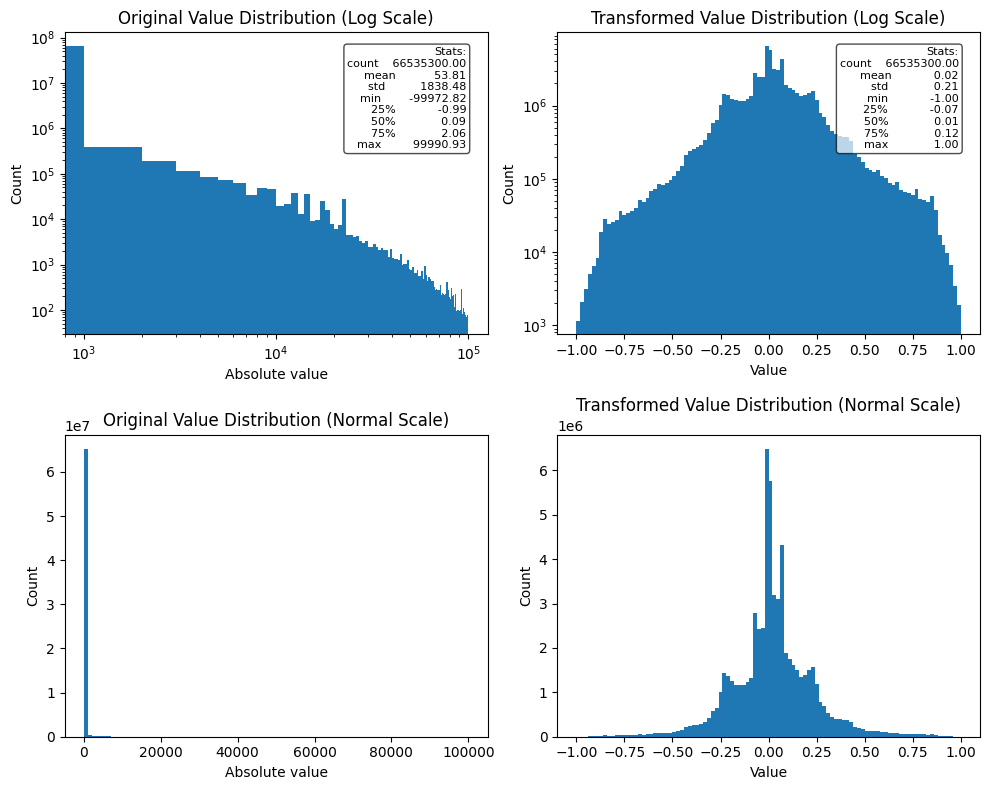

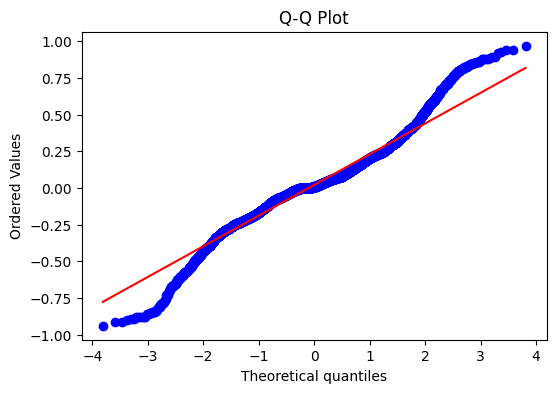

Number of outliers detected using z-score method: 1219329
Number of outliers detected using IQR method: 5091952


In [7]:
plot_value_distributions(values, val_transformed)
analyze_outliers(val_transformed)

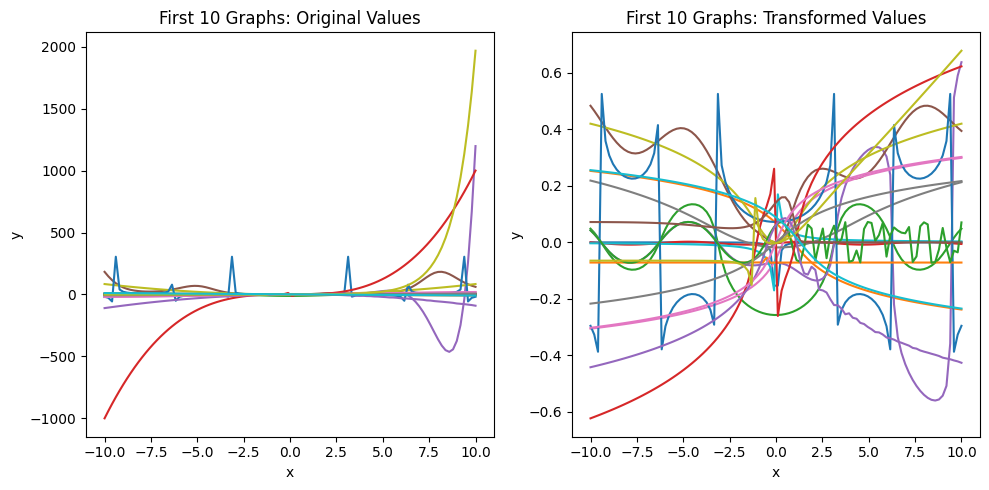

In [15]:
i = 60
plot_values(val_x, values, val_transformed, idx=np.arange(i, i+20))

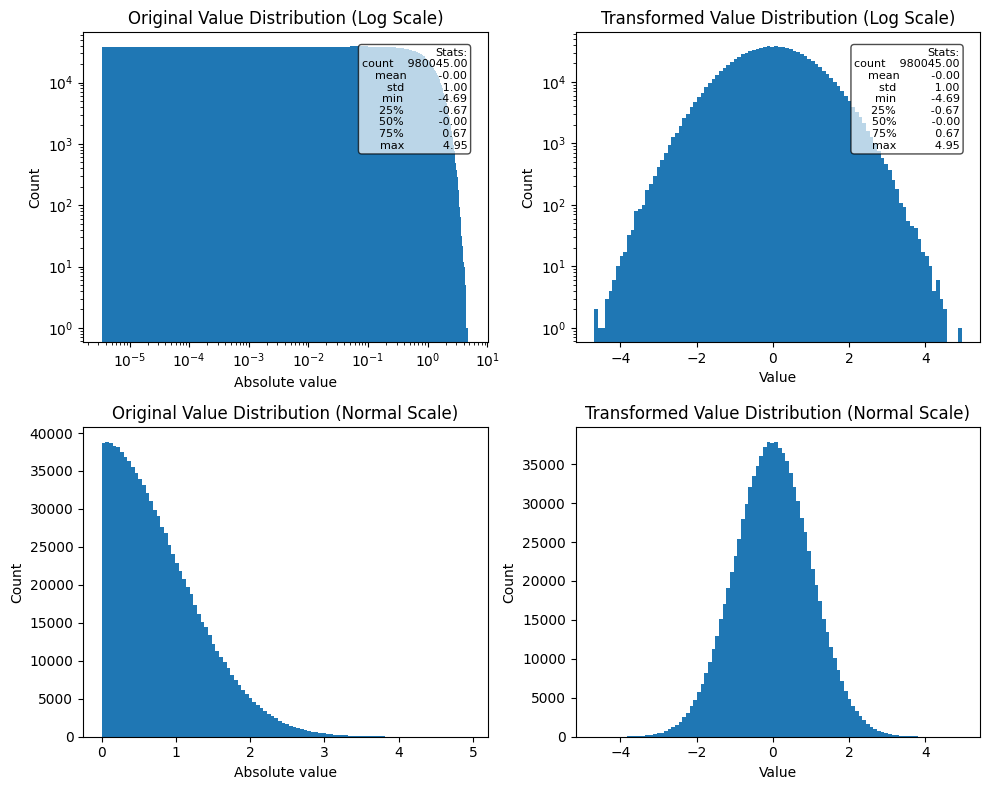

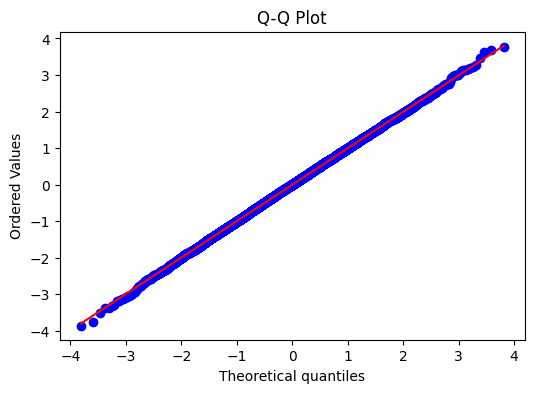

Number of outliers detected using z-score method: 2711
Number of outliers detected using IQR method: 6985


In [7]:
mask = (syntax[:, :, syntax_cats.index('CON')] == 1)
active_consts = consts[mask]

plot_value_distributions(active_consts, active_consts)
analyze_outliers(active_consts)

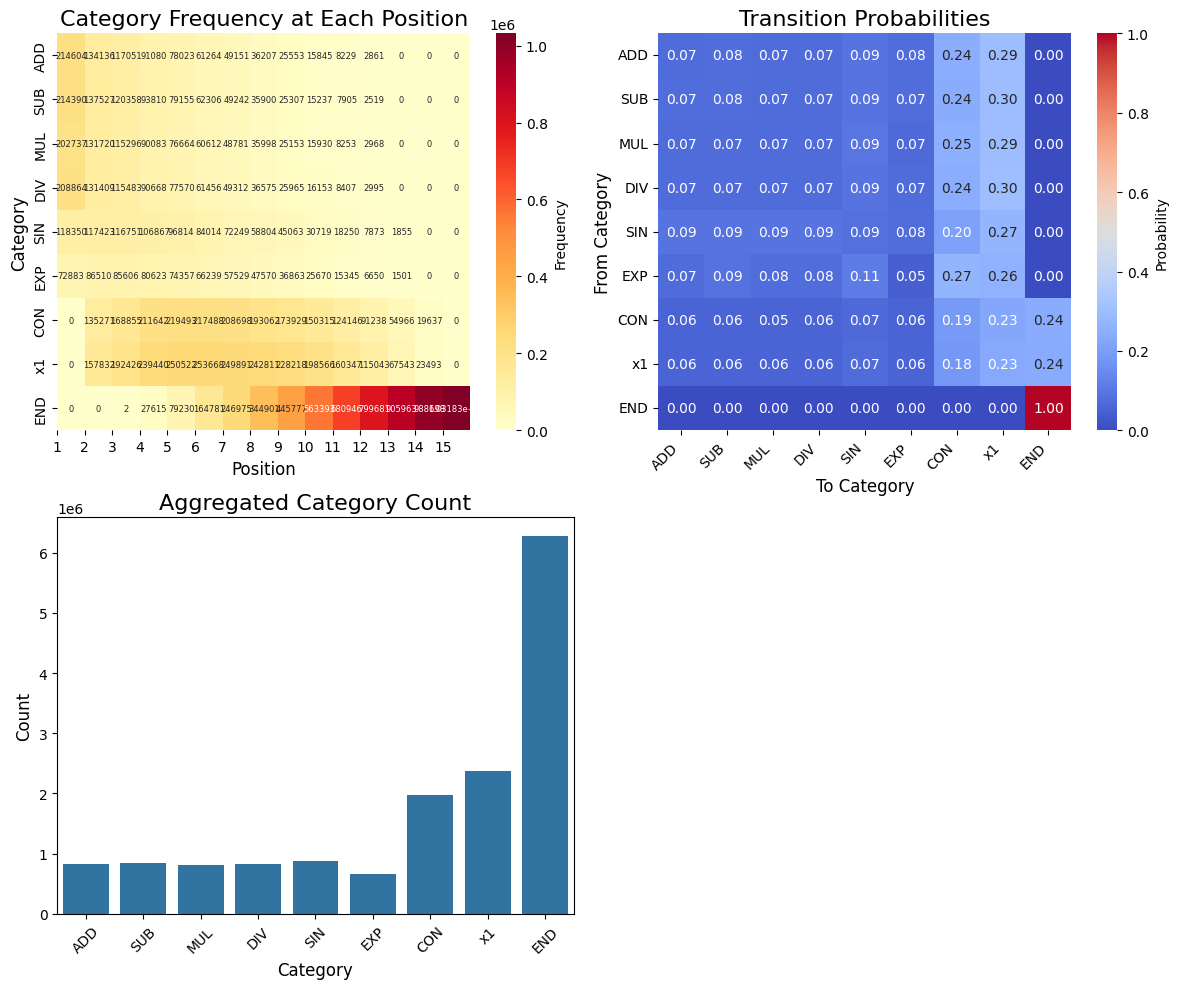

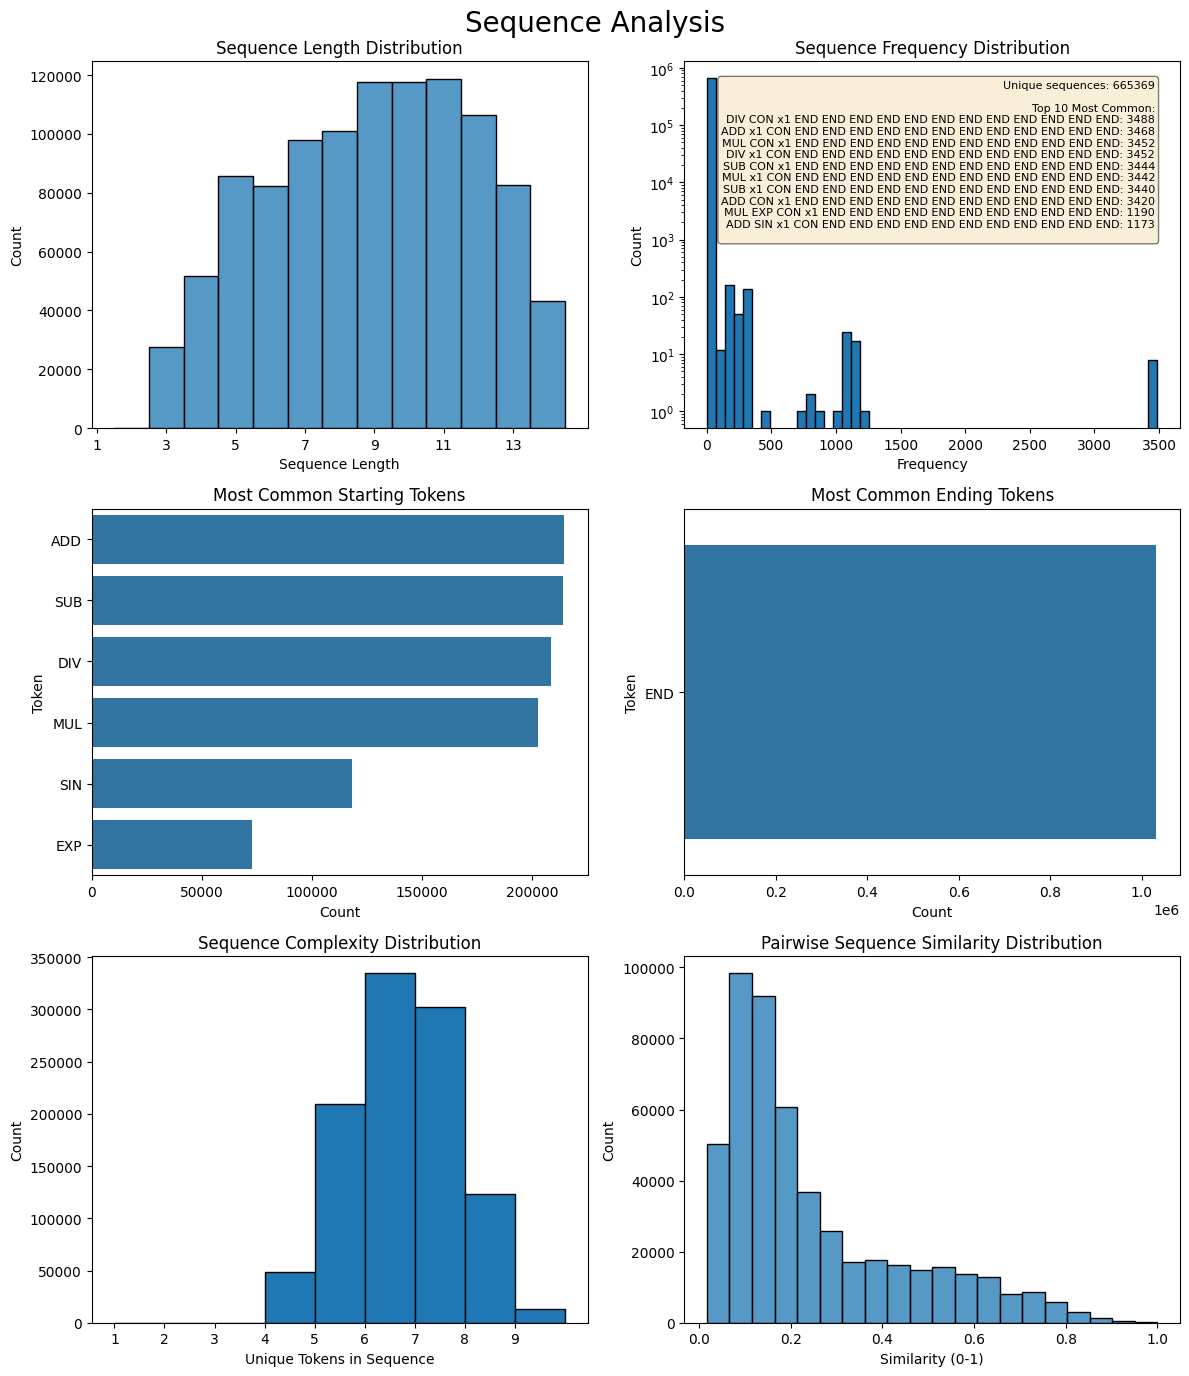

In [8]:
analyze_syntax_tokens(syntax, syntax_cats)
analyze_sequences(syntax, syntax_cats)

### Dev for new filter functions

Filters:
- Absolute value
- 1st derivative

In [13]:
print(f"Values min: {values.min()}, max: {values.max()}")

# Calculate first derivative over each row
first_derivative = np.diff(values, axis=1)/np.diff(val_x, axis=0).T
print(f"First derivative min: {first_derivative.min()}, max: {first_derivative.max()}")

Values min: -99999.546875, max: 99990.0
First derivative min: -99948.6015625, max: 99969.5


In [19]:
values.shape

(1031828, 100)

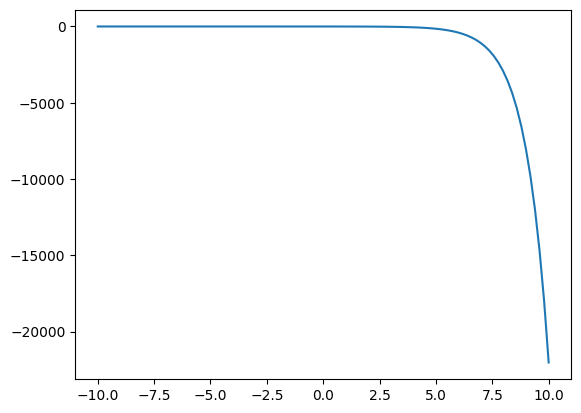

In [78]:
plt.plot(val_x, values[9, :])

In [69]:
C_f

array([2.58551955e+04, 2.09603823e+02, 1.74372740e+04, 1.84029818e+03,
       1.31715839e+02, 2.02719247e+06, 0.00000000e+00, 3.09525017e+03,
       2.11226995e+06, 2.11226996e+06])

In [67]:
C_f = np.sum(np.abs(freqs * ft), axis=1)

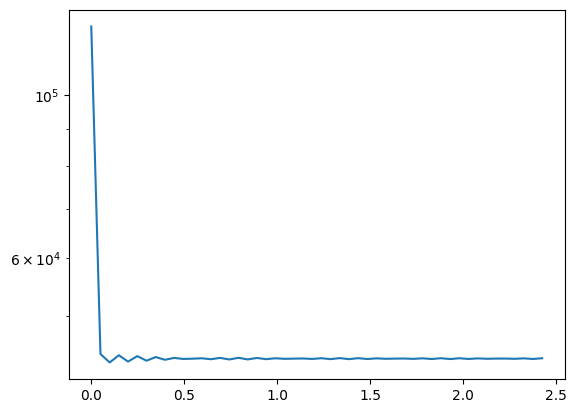

In [51]:
# FFT test
from matplotlib import pyplot as plt

a = values[:10, :]
ft = np.fft.fft(a, axis=1)
freqs = np.fft.fftfreq(a.shape[1], d=val_x[1]-val_x[0])





plt.plot(freqs[freqs>=0], np.abs(ft[0, freqs>=0])**2)
plt.yscale('log')
plt.show()


In [17]:
max_derivative=10
max_second_derivative=5
value_range=(-1e5, 1e5)
max_oscillations=10
max_jump=10

# Prepare the results array
n_samples = values.shape[0]
results = np.ones((n_samples, 5), dtype=bool)

# First derivative check
first_derivative = np.diff(values, axis=1) / np.diff(val_x, axis=0).T
results[:, 0] = np.max(np.abs(first_derivative), axis=1) <= max_derivative

# Second derivative check
second_derivative = np.diff(first_derivative, axis=1) / np.diff(val_x[:-1], axis=0).T
results[:, 1] = np.max(np.abs(second_derivative), axis=1) <= max_second_derivative

# Value range check
results[:, 2] = (np.min(values, axis=1) >= value_range[0]) & (np.max(values, axis=1) <= value_range[1])

# Oscillation check
mean = np.mean(values, axis=1, keepdims=True)
sign_changes = np.diff((values - mean) > 0, axis=1)
results[:, 3] = np.sum(sign_changes != 0, axis=1) <= max_oscillations

# Continuity check
results[:, 4] = np.max(np.abs(np.diff(values, axis=1)), axis=1) <= max_jump

In [133]:
is_valid.sum()/len(is_valid)

np.float64(0.676835674162748)

12 valid functions out of 20


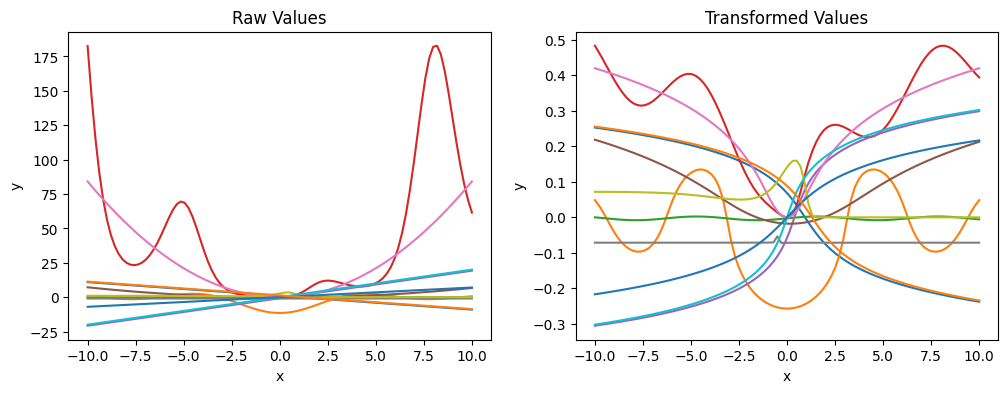

In [130]:
is_valid = (np.all(np.abs(first_derivative) < 1000, axis=1) & \
            np.all(np.abs(second_derivative) < 1000, axis=1) & \
            np.all(np.abs(third_derivative) < 1000, axis=1) & \
            np.all(np.abs(fourth_derivative) < 1000, axis=1))
i = 60

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot raw values
ax1.plot(val_x, values[i:i+20, :][is_valid[i:i+20], :].T)
ax1.set_title('Raw Values')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot transformed values
ax2.plot(val_x, val_transformed[i:i+20, :][is_valid[i:i+20], :].T)
ax2.set_title('Transformed Values')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
print(f'{np.sum(is_valid[i:i+20])} valid functions out of 20')

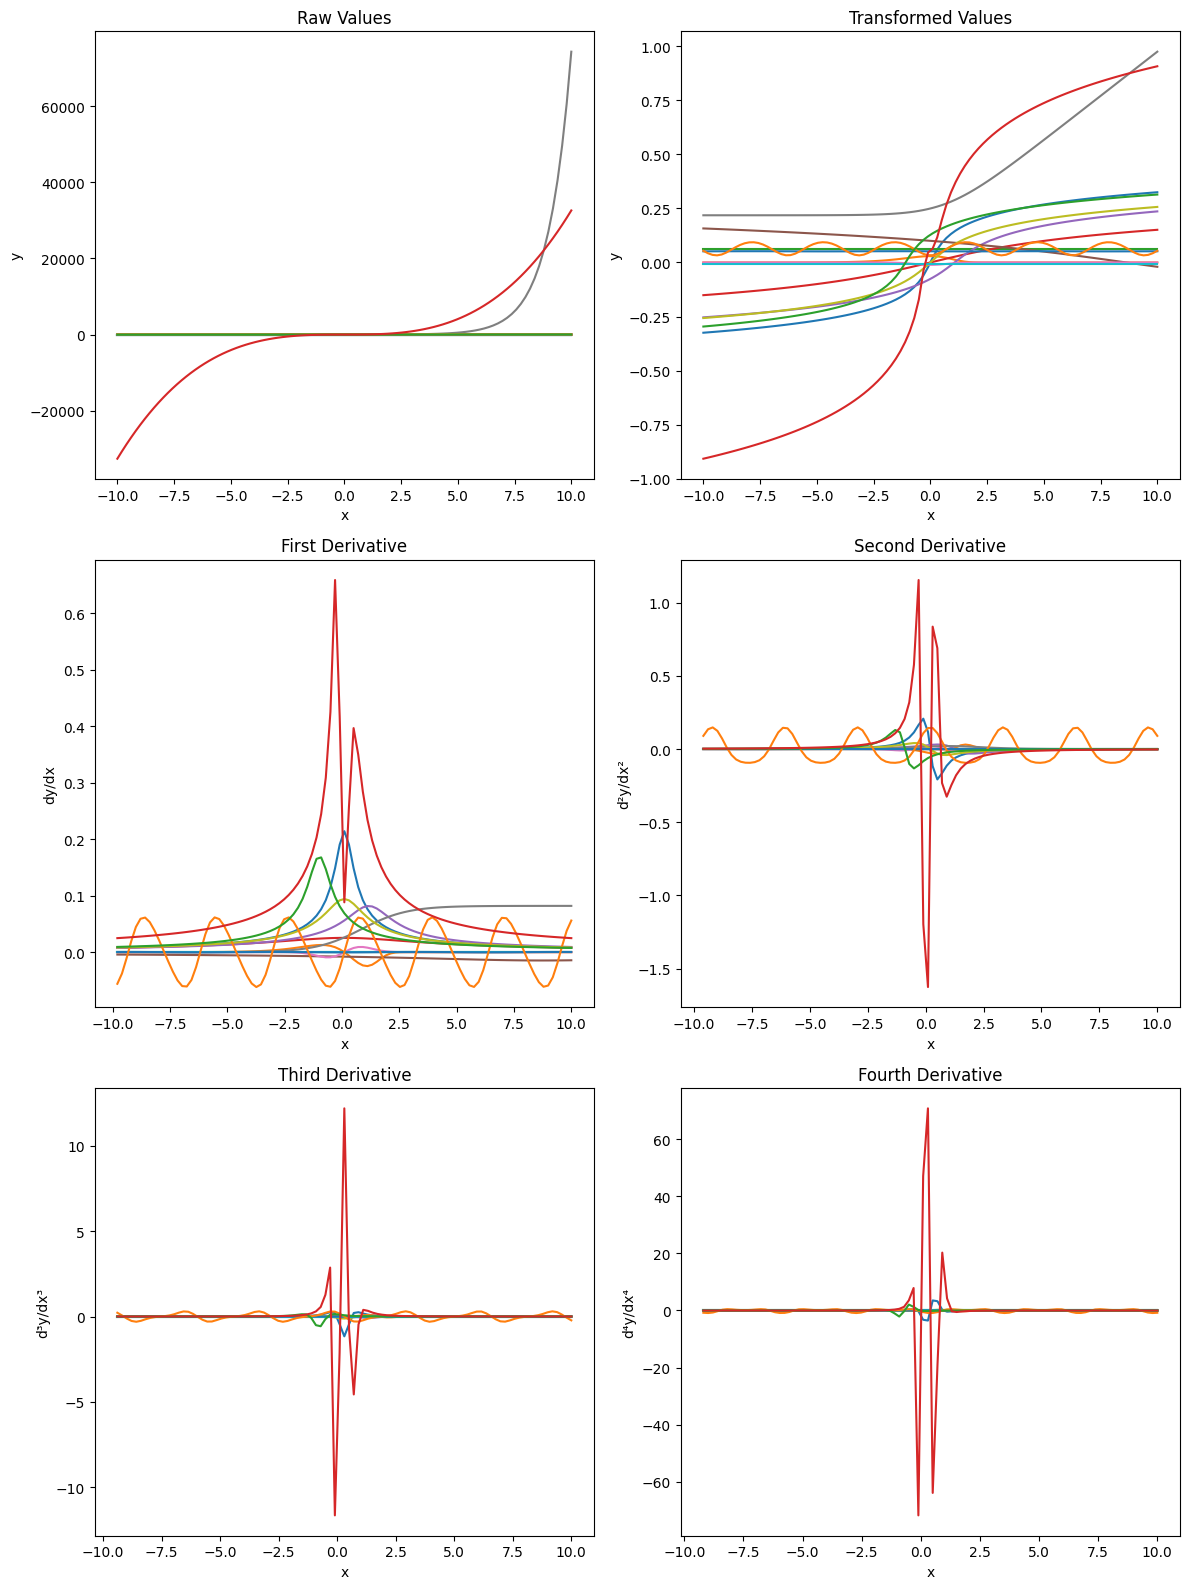

In [138]:
# Plot the ith function (raw values, transformed values, and derivatives)
i = 100  # Using the same index as in the previous example

first_derivative = np.diff(val_transformed, axis=1) / np.diff(val_x, axis=0).T
second_derivative = np.diff(first_derivative, axis=1) / np.diff(val_x[:-1], axis=0).T
third_derivative = np.diff(second_derivative, axis=1) / np.diff(val_x[:-2], axis=0).T
fourth_derivative = np.diff(third_derivative, axis=1) / np.diff(val_x[:-3], axis=0).T

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 16))

# Plot raw values
ax1.plot(val_x, values[i:i+20, :][is_valid[i:i+20], :].T)
ax1.set_title('Raw Values')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot transformed values
ax2.plot(val_x, val_transformed[i:i+20, :][is_valid[i:i+20], :].T)
ax2.set_title('Transformed Values')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Plot first derivative
ax3.plot(val_x[1:], first_derivative[i:i+20, :][is_valid[i:i+20], :].T)
ax3.set_title('First Derivative')
ax3.set_xlabel('x')
ax3.set_ylabel('dy/dx')

# Plot second derivative
ax4.plot(val_x[2:], second_derivative[i:i+20, :][is_valid[i:i+20], :].T)
ax4.set_title('Second Derivative')
ax4.set_xlabel('x')
ax4.set_ylabel('d²y/dx²')

# Plot third derivative
ax5.plot(val_x[3:], third_derivative[i:i+20, :][is_valid[i:i+20], :].T)
ax5.set_title('Third Derivative')
ax5.set_xlabel('x')
ax5.set_ylabel('d³y/dx³')

# Plot fourth derivative
ax6.plot(val_x[4:], fourth_derivative[i:i+20, :][is_valid[i:i+20], :].T)
ax6.set_title('Fourth Derivative')
ax6.set_xlabel('x')
ax6.set_ylabel('d⁴y/dx⁴')

plt.tight_layout()
plt.show()

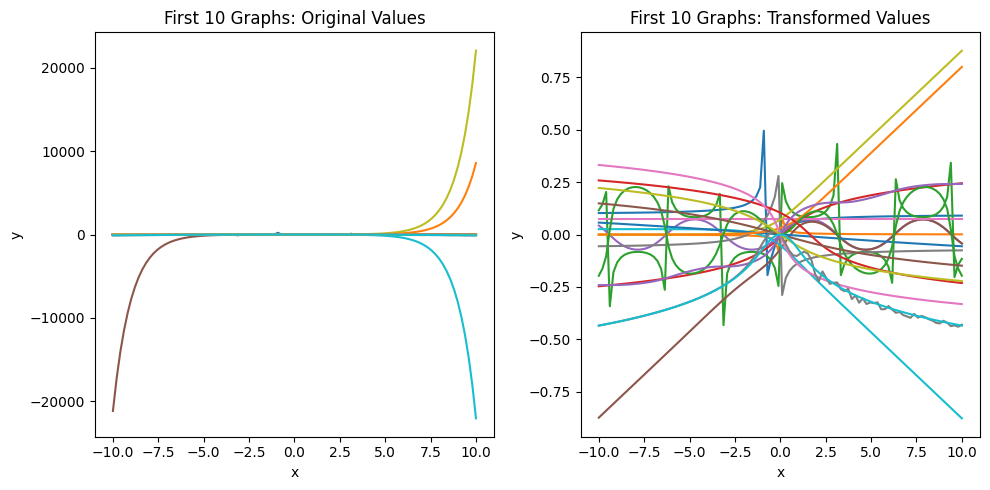

In [86]:
i = 0
plot_values(val_x, values, val_transformed, idx=np.arange(i, i+20))

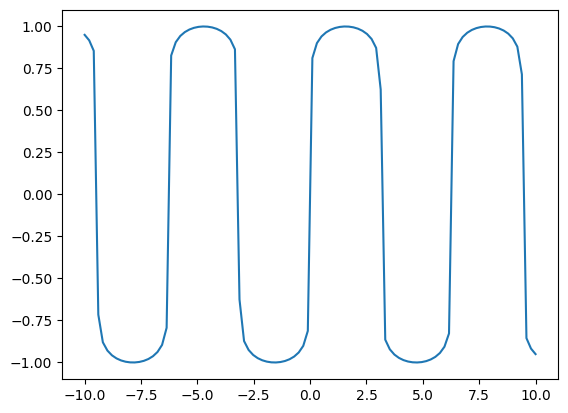

In [85]:
plt.plot(val_x, value_transform(torch.tensor(1e5*np.sin(val_x))))
